# Optimization of Degree Distributions on the BEC

This code is provided as supplementary material of the lecture Channel Coding 2 - Advanced Methods.

This code illustrates
* Using linear programming to optimize degree distributions on the BEC

In [1]:
import numpy as np
import matplotlib.pyplot as plot
from ipywidgets import interactive
import ipywidgets as widgets
import math
from pulp import *
%matplotlib inline  

We specify the check node degree distribution polynomial $\rho(Z)$ by fixing the average check node degree $d_{\mathtt{c},\text{avg}}$ and assuming that the code contains only check nodes with degrees $\tilde{d}_{\mathtt{c}} := \lfloor d_{\mathtt{c},\text{avg}}\rfloor$ and $\tilde{d}_{\mathtt{c}}+1$. This is the so-called check-concentrated degree distribution. As shown in the lecture, we have:
$$
\rho(Z) = \frac{\tilde{d}_{\mathtt{c}}(\tilde{d}_{\mathtt{c}}+1-d_{\mathtt{c},\text{avg}})}{d_{\mathtt{c},\text{avg}}}Z^{\tilde{d}_{\mathtt{c}}-1} + \frac{d_{\mathtt{c},\text{avg}}-\tilde{d}_{\mathtt{c}}(\tilde{d}_{\mathtt{c}}+1-d_{\mathtt{c},\text{avg}})}{d_{\mathtt{c},\text{avg}}}Z^{\tilde{d}_{\mathtt{c}}}
$$
The following function converts $d_{\mathtt{c},\text{avg}}$ into a polynomial $\rho(Z)$ which is given as an array where the first entry corresponds to the largest exponents and the last entry corresponds to the constant part.

In [2]:
# returns rho polynomial (highest exponents first) corresponding to average check node degree c_avg
def c_avg_to_rho(c_avg):
    ct = math.floor(c_avg)
    r1 = ct*(ct+1-c_avg)/c_avg
    r2 = (c_avg - ct*(ct+1-c_avg))/c_avg
    rho_poly = np.concatenate(([r2,r1], np.zeros(ct-1))) 
    return rho_poly

The following function solves the optimization problem that returns the best $\lambda(Z)$ for a given BEC erasure probability $\epsilon$, for an average check node degree $d_{\mathtt{c},\text{avg}}$, and for a maximum variable node degree $d_{\mathtt{v},\max}$. This optimization problem is derived in the lecture as
$$
\begin{aligned}
& \underset{\lambda_1,\ldots,\lambda_{d_{\mathtt{v},\max}}}{\text{maximize}} & & \sum_{i=1}^{d_{\mathtt{v},\max}}\frac{\lambda_i}{i} \\
& \text{subject to} & & \lambda_1 = 0 \\
& & & \lambda_i \geq 0, \quad \forall i \in\{2,3,\ldots,d_{\mathtt{v},\max}\} \\
& & & \sum_{i=2}^{d_{\mathtt{v},\max}}\lambda_i = 1 \\
& & & \sum_{i=2}^{d_{\mathtt{v},\max}}\lambda_i\cdot \epsilon(1-\rho(1-\tilde{\xi}_j))^{i-1}-\tilde{\xi}_j \leq 0,\quad  \forall j \in \{1,\ldots, D\} \\
& & & \lambda_2 \leq \frac{1}{\epsilon\rho^\prime(1)} = \frac{1}{\epsilon\sum_{i=2}^{d_{\mathtt{c},\max}}(i-1)\rho_i}
\end{aligned}
$$

If this optimization problem is feasible, then the function returns the polynomial $\lambda(Z)$ as a coefficient array where the first entry corresponds to the largest exponent ($\lambda_{d_{\mathtt{v},\max}}$) and the last entry to the lowest exponent ($\lambda_1$). If the optimization problem has no solution (e.g., it is unfeasible), then the empty vector is returned.

In [3]:
def find_best_lambda(epsilon, v_max, c_avg):
    rho = c_avg_to_rho(c_avg)
    
    # quantization of EXIT chart
    D = 500
    xi_range = np.arange(1.0, D+1, 1)/D                    
    
    # Linear Programming model, maximize target expression
    model = pulp.LpProblem("Finding best lambda problem", pulp.LpMaximize)

    # definition of variables, v_max entries \lambda_i that are between 0 and 1 (implicit declaration of constraint 2)
    v_lambda = pulp.LpVariable.dicts("lambda", range(v_max),0,1)
    
    # objective function
    cv = 1/np.arange(v_max,0,-1)    
    model += pulp.lpSum(v_lambda[i]*cv[i] for i in range(v_max)) 
    
    # constraints
    # constraint 1, no variable nodes of degree 1
    model += v_lambda[v_max-1] == 0
    
    # constraint 3, sum of lambda_i must be 1
    model += pulp.lpSum(v_lambda[i] for i in range(v_max))==1
            
    # constraints 4, fixed point condition for all the descrete xi values  (a total number of D, for each \xi)  
    for xi in xi_range:
        model += pulp.lpSum(v_lambda[j] * epsilon * (1-np.polyval(rho,1.0-xi))**(v_max-1-j) for j in range(v_max))-xi <= 0
    
    # constraint 5, stability condition
    model += v_lambda[v_max-2] <= 1/epsilon/np.polyval(np.polyder(rho),1.0)
    
    model.solve()
    if model.status != 1:
        r_lambda = []
    else:
        r_lambda = [v_lambda[i].varValue for i in range(v_max)]
    return r_lambda

As an example, we consider the case of optimization carried out in the lecture after 9 iterations, where we have $\epsilon = 0.2949219$ and $d_{\mathtt{c},\text{avg}} = 12.98$ with $d_{\mathtt{v},\max}=16$

In [4]:
best_lambda = find_best_lambda(0.2949219, 16, 12.98)
print(np.poly1d(best_lambda, variable='Z'))

        15           5          4          2
0.3391 Z  + 0.03524 Z + 0.2009 Z + 0.1423 Z + 0.2824 Z


In the following, we provide an interactive widget that allows you to choose the parameters of the optimization yourself and get the best possible $\lambda(Z)$. Additionally, the EXIT chart is plotted to visualize the good fit of the obtained degree distribution.

In [8]:
def best_lambda_interactive(epsilon, c_avg, v_max):
    # get lambda and rho polynomial from optimization and from c_avg, respectively
    p_lambda = find_best_lambda(epsilon, v_max, c_avg)
    p_rho = c_avg_to_rho(c_avg)    
    
    # if optimization successful, compute rate and show plot
    if not p_lambda:
        print('Optimization infeasible, no solution found')
    else:
        design_rate = 1 - np.polyval(np.polyint(p_rho),1)/np.polyval(np.polyint(p_lambda),1)
        if design_rate <= 0:
            print('Optimization feasible, but no code with positive rate found')
        else:
            print("Lambda polynomial:")
            print(np.poly1d(p_lambda, variable='Z'))
            print("Design rate r_d = %1.3f" % design_rate)
            
            # Plot EXIT-Chart
            print("EXIT Chart:")
            plot.figure(3)    
            x = np.linspace(0, 1, num=100)
            y_v = [1 - epsilon*np.polyval(p_lambda, 1-xv) for xv in x]
            y_c = [np.polyval(p_rho,xv) for xv in x]
            plot.plot(x, y_v, '#7030A0')
            plot.plot(y_c, x, '#008000')            
            plot.axis('equal')
            plot.gca().set_aspect('equal', adjustable='box')
            plot.xlim(0,1)
            plot.ylim(0,1)     
            plot.xlabel('$I^{[A,V]}$, $I^{[E,C]}$')
            plot.ylabel('$I^{[E,V]}$, $I^{[A,C]}$')
            plot.grid()
            plot.show()

interactive_plot = interactive(best_lambda_interactive, \
                               epsilon=widgets.FloatSlider(min=0.01,max=1,step=0.001,value=0.5, continuous_update=False, description=r'\(\epsilon\)',layout=widgets.Layout(width='50%')), \
                               c_avg = widgets.FloatSlider(min=3,max=20,step=0.1,value=4, continuous_update=False, description=r'\(d_{\mathtt{c},\text{avg}}\)'), \
                               v_max = widgets.IntSlider(min=3, max=20, step=1, value=16, continuous_update=False, description=r'\(d_{\mathtt{v},\max}\)'))
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='\\(\\epsilon\\)', layout=La…

Now, we carry out the optimization over a wide range of $d_{\mathtt{c},\text{avg}}$ values for a given $\epsilon$ and find the largest possible rate.

In [9]:
def find_best_rate(epsilon, v_max, c_max):
    c_range = np.linspace(3, c_max, num=100)
    rates = np.zeros_like(c_range)
    
    
    # loop over all c_avg, add progress bar
    f = widgets.FloatProgress(min=0, max=np.size(c_range))
    display(f)
    for index,c_avg in enumerate(c_range):
        f.value += 1
        p_lambda = find_best_lambda(epsilon, v_max, c_avg)        
        p_rho = c_avg_to_rho(c_avg) 
        if p_lambda:
            design_rate = 1 - np.polyval(np.polyint(p_rho),1)/np.polyval(np.polyint(p_lambda),1)
            if design_rate >= 0:
                rates[index] = design_rate
    
    # find largest rate
    largest_rate_index = np.argmax(rates)
    best_lambda = find_best_lambda(epsilon, v_max, c_range[largest_rate_index])
    print("Found best code of rate %1.3f for average check node degree of %1.2f" % (rates[largest_rate_index], c_range[largest_rate_index]))
    print("Corresponding lambda polynomial")
    print(np.poly1d(best_lambda, variable='Z'))
    
    # Plot curve with all obtained results
    plot.figure(4, figsize=(10,3))    
    plot.plot(c_range, rates, 'b')
    plot.plot(c_range[largest_rate_index], rates[largest_rate_index], 'bs')
    plot.xlim(3, c_max)
    plot.ylim(0, (1.1*(1-epsilon)))
    plot.xlabel('$d_{c,avg}$')
    plot.ylabel('design rate $r_d$')
    plot.grid()
    plot.show()
    return rates[largest_rate_index]

interactive_optim = interactive(find_best_rate, \
                               epsilon=widgets.FloatSlider(min=0.01,max=1,step=0.001,value=0.5, continuous_update=False, description=r'\(\epsilon\)',layout=widgets.Layout(width='50%')), \
                               v_max = widgets.IntSlider(min=3, max=20, step=1, value=16, continuous_update=False, description=r'\(d_{\mathtt{v},\max}\)'), \
                               c_max = widgets.IntSlider(min=3, max=40, step=1, value=22, continuous_update=False, description=r'\(d_{\mathtt{c},\max}\)'))
output = interactive_optim.children[-1]
output.layout.height = '400px'
interactive_optim

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='\\(\\epsilon\\)', layout=La…

Run binary search to find best irregular code for a given target rate on the BEC.

Running optimization for epsilon = 0.50000


FloatProgress(value=0.0)

Found best code of rate 0.493 for average check node degree of 7.22
Corresponding lambda polynomial
        15           5          4          2
0.3053 Z  + 0.02216 Z + 0.2052 Z + 0.1477 Z + 0.3196 Z


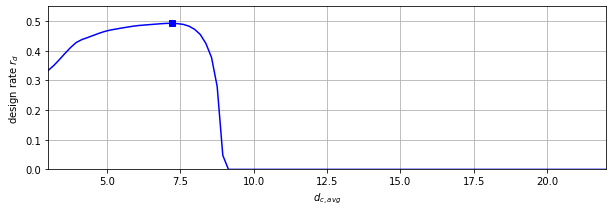

Running optimization for epsilon = 0.25000


FloatProgress(value=0.0)

Found best code of rate 0.744 for average check node degree of 15.47
Corresponding lambda polynomial
        15           5         4          2
0.3437 Z  + 0.04071 Z + 0.199 Z + 0.1411 Z + 0.2755 Z


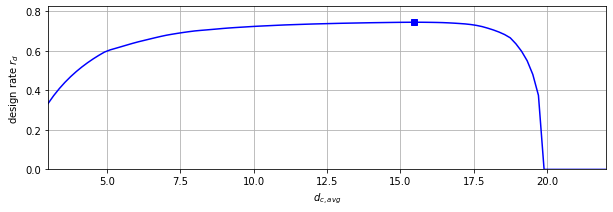

Running optimization for epsilon = 0.37500


FloatProgress(value=0.0)

Found best code of rate 0.618 for average check node degree of 9.91
Corresponding lambda polynomial
        15           5          4          2
0.3121 Z  + 0.06686 Z + 0.1734 Z + 0.1497 Z + 0.298 Z


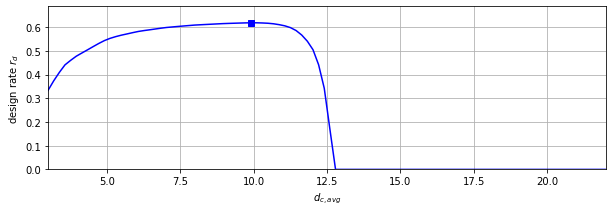

Running optimization for epsilon = 0.31250


FloatProgress(value=0.0)

Found best code of rate 0.681 for average check node degree of 12.21
Corresponding lambda polynomial
       15           5         4         2
0.338 Z  + 0.03038 Z + 0.205 Z + 0.142 Z + 0.2845 Z


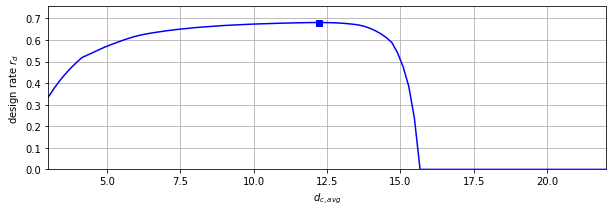

Running optimization for epsilon = 0.28125


FloatProgress(value=0.0)

Found best code of rate 0.713 for average check node degree of 13.75
Corresponding lambda polynomial
        15           5          4          2
0.3517 Z  + 0.00982 Z + 0.2219 Z + 0.1383 Z + 0.2783 Z


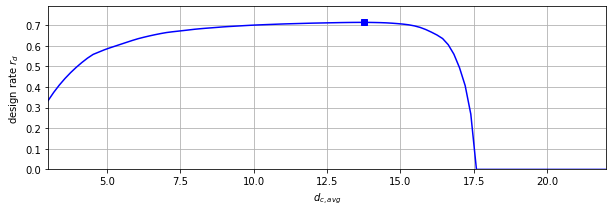

Running optimization for epsilon = 0.29688


FloatProgress(value=0.0)

Found best code of rate 0.697 for average check node degree of 12.98
Corresponding lambda polynomial
        15            5          4          2
0.3517 Z  + 0.000839 Z + 0.2289 Z + 0.1377 Z + 0.2809 Z


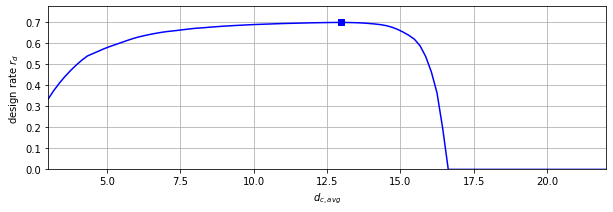

Running optimization for epsilon = 0.28906


FloatProgress(value=0.0)

Found best code of rate 0.705 for average check node degree of 13.36
Corresponding lambda polynomial
        15            5          4          2
0.3522 Z  + 0.004647 Z + 0.2262 Z + 0.1378 Z + 0.2791 Z


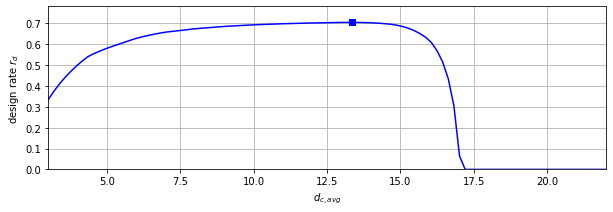

Running optimization for epsilon = 0.29297


FloatProgress(value=0.0)

Found best code of rate 0.701 for average check node degree of 13.17
Corresponding lambda polynomial
        15            5          4          2
0.3516 Z  + 0.009329 Z + 0.2202 Z + 0.1391 Z + 0.2798 Z


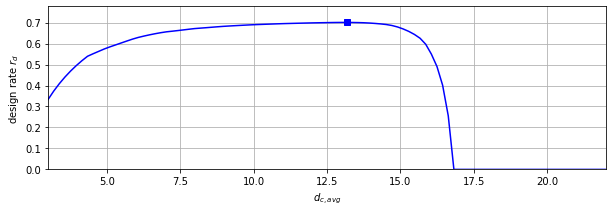

Running optimization for epsilon = 0.29492


FloatProgress(value=0.0)

Found best code of rate 0.699 for average check node degree of 12.98
Corresponding lambda polynomial
        15           5          4          2
0.3391 Z  + 0.03528 Z + 0.2009 Z + 0.1423 Z + 0.2824 Z


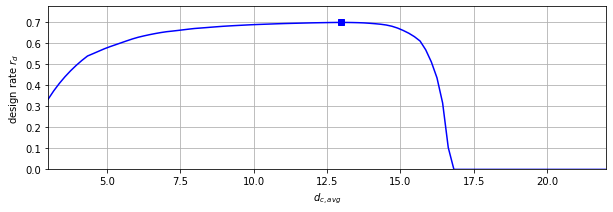

In [9]:
target_rate = 0.7
dv_max = 16
dc_max = 22

T_Delta = 0.001
epsilon = 0.5
Delta_epsilon = 0.5

while Delta_epsilon >= T_Delta:   
    print('Running optimization for epsilon = %1.5f' % epsilon)
    
    rate = find_best_rate(epsilon, dv_max, dc_max)
    if rate > target_rate:
        epsilon = epsilon + Delta_epsilon / 2
    else:
        epsilon = epsilon - Delta_epsilon / 2
        
    Delta_epsilon = Delta_epsilon / 2